In [2]:
import pandas as pd
import polars as pl
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
pd.set_option('display.width', 150)
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
sns.set()

In [3]:
dates = ['session_start', 'session_end', 'session_date', 'order_dt']
df = pd.read_csv('ecom_go_2.csv', parse_dates=dates)
df_pl = pl.from_pandas(df)

print(df.shape)
print(df.columns.tolist())

(1009, 19)
['user_id', 'region', 'device', 'channel', 'session_start', 'session_end', 'sessiondurationsec', 'session_date', 'month', 'day', 'hour_of_day', 'order_dt', 'revenue', 'payment_type', 'promo_code', 'final_price', 'time_of_day', 'payer', 'week']


In [4]:
df_unchanged = df.copy()
print(df_unchanged.shape, df_unchanged['payer'].sum())

df_replaced = df.copy()
df_replaced['revenue'] = np.where(df_replaced['revenue'] == 100000, 9999, df_replaced['revenue'])
df_replaced['revenue'] = np.where(df_replaced['revenue'] == 1, 4999, df_replaced['revenue'])
print(df_replaced.shape, df_replaced['payer'].sum())

df_removed = df.copy()
to_remove = df[df['revenue'].isin([1, 100000])].index
df_removed.drop(to_remove, inplace=True)
print(df_removed.shape, df_removed['payer'].sum())


dfs = [(df_unchanged, "ORIGINAL DATAFRAME:"), 
       (df_replaced, "REPLACED DATAFRAME:"), 
       (df_removed, "REMOVED DATAFRAME:")]

(1009, 19) 282
(1009, 19) 282
(1003, 19) 276


### `Влияет ли тип устройства на количество покупок в день по каждому региону?`

United States 6.495640408149409e-27
France 3.535860432523009e-16
Germany 1.3211037098502413e-15
UK 2.7564709916866203e-15


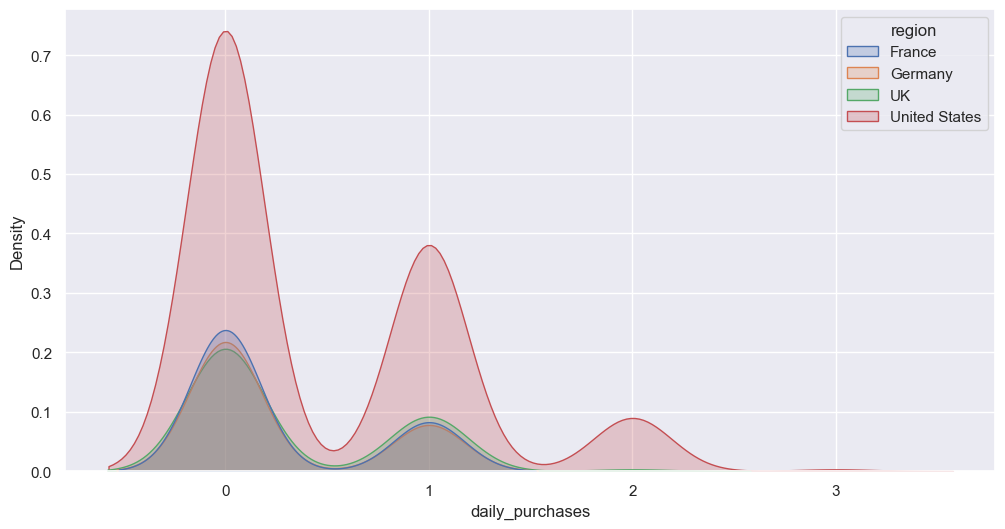

In [4]:
def normality_test(df):
    grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)
    
    plt.figure(figsize=(12,6))
    sns.kdeplot(grouped, x='daily_purchases', hue='region', fill=True)
    
    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]['daily_purchases']
        statistic, p_value = stats.shapiro(region_data)
        print(region, p_value)

normality_test(df)

In [5]:
def test_hypothesis_1(df):
    grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)

    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]

        groups = [group['daily_purchases'].values for device, group in region_data.groupby('device')]
        stat, p = stats.kruskal(*groups)
        print(region, round(p, 6))
        
test_hypothesis_1(df)

# for df_go, df_name in dfs:
#     print(df_name, test_hypothesis_1(df_go))
#     print()

United States 0.330828
France 0.191148
Germany 0.641236
UK 0.758526


### `Влияет ли тип устройства на совершение покупки в определенный день (Да или Нет) в каждом регионе? (Дополнительная гипотеза)`

In [6]:
def test_hypothesis_2(df):
    grouped = df.groupby(['region', 'device', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)
    grouped['purchase_made'] = grouped['daily_purchases'].apply(lambda x: 1 if x > 0 else 0)
    
    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]
        
        crosstab = pd.crosstab(region_data['device'], region_data['purchase_made'])
        chi2, p, dof, expected = stats.chi2_contingency(crosstab)
        print(region, round(p, 6))
        
test_hypothesis_2(df)

United States 0.378244
France 0.187342
Germany 0.637253
UK 0.792335


### `Влияет ли тип рекламного канала на количество покупок в день по каждому региону?`

United States 3.6089853521507336e-24
France 2.2988170659926374e-15
Germany 3.702049171617313e-15
UK 4.312893156913889e-15


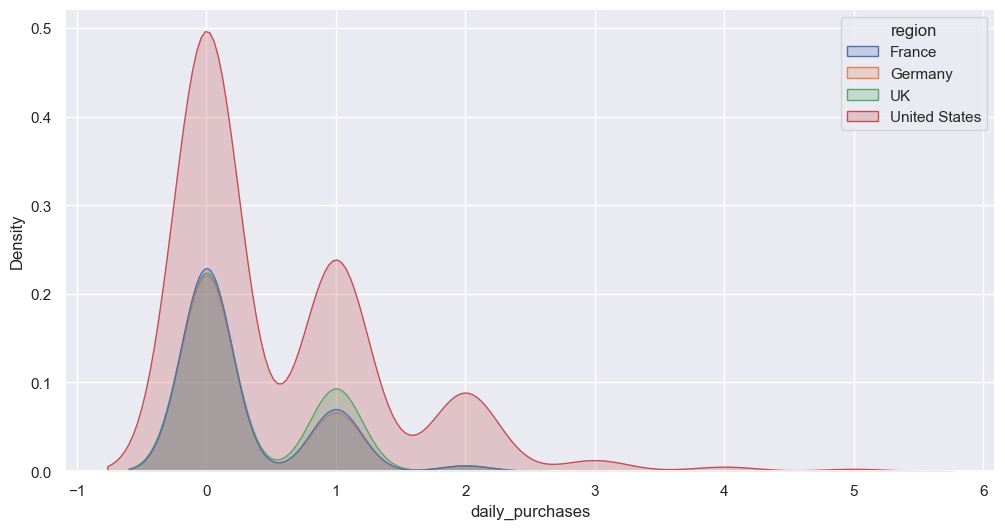

In [5]:
def normality_test(df):
    grouped = df.groupby(['region', 'channel', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)
    
    plt.figure(figsize=(12,6))
    sns.kdeplot(grouped, x='daily_purchases', hue='region', fill=True)
    
    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]['daily_purchases']
        statistic, p_value = stats.shapiro(region_data)
        print(region, p_value)

normality_test(df_replaced)

In [22]:
def test_hypothesis_3(df):
    grouped = df.groupby(['region', 'channel', 'session_date'])['payer'].sum().reset_index()
    grouped.rename(columns={'payer': 'daily_purchases'}, inplace=True)

    for region in df['region'].unique():
        region_data = grouped[grouped['region'] == region]

        groups = [group['daily_purchases'].values for channel, group in region_data.groupby('channel')]
        stat, p = stats.kruskal(*groups)
        print(region, round(p, 6))
        
test_hypothesis_3(df)

# for df_go, df_name in dfs:
#     print(df_name, test_hypothesis_3(df_go))
#     print()

United States 0.025528
France 0.12642
Germany 0.951457
UK 0.774942


                group1               group2  meandiff   p-adj   lower   upper  reject
0              organic  контекстная реклама   -0.1818  0.8082 -0.7071  0.3435   False
1              organic   реклама у блогеров   -0.2294  0.4445 -0.6269  0.1681   False
2              organic      социальные сети    0.2000  0.1568 -0.0465  0.4466   False
3  контекстная реклама   реклама у блогеров   -0.0476  0.9970 -0.6540  0.5588   False
4  контекстная реклама      социальные сети    0.3819  0.2318 -0.1382  0.9020   False
5   реклама у блогеров      социальные сети    0.4295  0.0247  0.0389  0.8201    True


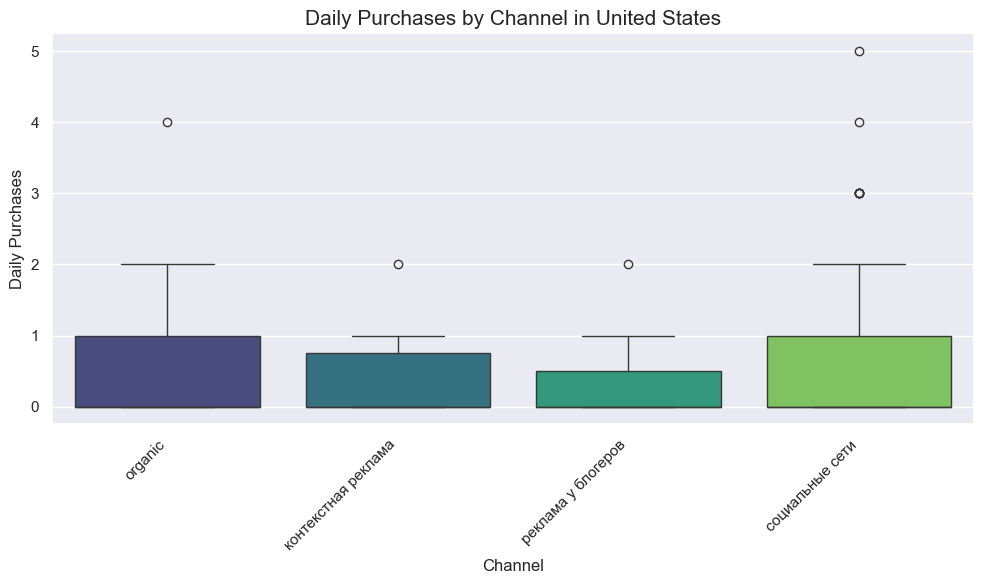

In [29]:
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def post_hoc_us_channels(df):
    us_data = df[df['region'] == 'United States']
    grouped = us_data.groupby(['channel', 'session_date'])['payer'].sum().reset_index()
    
    tukey_results = pairwise_tukeyhsd(grouped['payer'], grouped['channel'])
    
    tukey_df = pd.DataFrame(data=tukey_results._results_table.data[1:], 
                            columns=tukey_results._results_table.data[0])
    
    return tukey_df

def create_us_channels_boxplot(df):
    us_data = df[df['region'] == 'United States']
    grouped = us_data.groupby(['channel', 'session_date'])['payer'].sum().reset_index()
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='channel', y='payer', data=grouped, hue='channel', palette='viridis')
    plt.title('Daily Purchases by Channel in United States', fontsize=15)
    plt.xlabel('Channel', fontsize=12)
    plt.ylabel('Daily Purchases', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plot.show()

tukey_results = post_hoc_us_channels(df_replaced)
print(tukey_results)

create_us_channels_boxplot(df)

### `Проверить гипотезу о том, что средний чек отличается в зависимости от региона?`

In [9]:
def test_hypothesis_4(df):
    groups = [group.values for region, group in df.query('revenue > 0').groupby('region')['revenue']]
    stat, p = stats.kruskal(*groups)
    
    return p

for df_go, df_name in dfs:
    print(df_name, test_hypothesis_4(df_go))
    print()

ORIGINAL DATAFRAME: 0.407846243062849

REPLACED DATAFRAME: 0.4794739794407604

REMOVED DATAFRAME: 0.8236248941574779



### `Проверить гипотезу о том, что средний чек отличается в зависимости от рекламного канала?`

In [10]:
def test_hypothesis_5(df):
    groups = [group.values for channel, group in df.query('revenue > 0').groupby('channel')['revenue']]
    stat, p = stats.kruskal(*groups)
    
    return p

for df_go, df_name in dfs:
    print(df_name, test_hypothesis_5(df_go))
    print()

ORIGINAL DATAFRAME: 0.5646670906613691

REPLACED DATAFRAME: 0.5467583327616166

REMOVED DATAFRAME: 0.6978967970065788



### `Проверить гипотезу о том, что средний чек отличается в зависимости от времени суток?`

In [11]:
def test_hypothesis_6(df):
    groups = [group.values for time_of_day, group in df.query('revenue > 0').groupby('time_of_day')['revenue']]
    stat, p = stats.kruskal(*groups)
    
    return p

for df_go, df_name in dfs:
    print(df_name, test_hypothesis_6(df_go))
    print()

ORIGINAL DATAFRAME: 0.2502626037110065

REPLACED DATAFRAME: 0.2136579783857801

REMOVED DATAFRAME: 0.1486870311736045



### `Есть ли взаимосвязь между продолжительностью сессии с суммой покупок?`

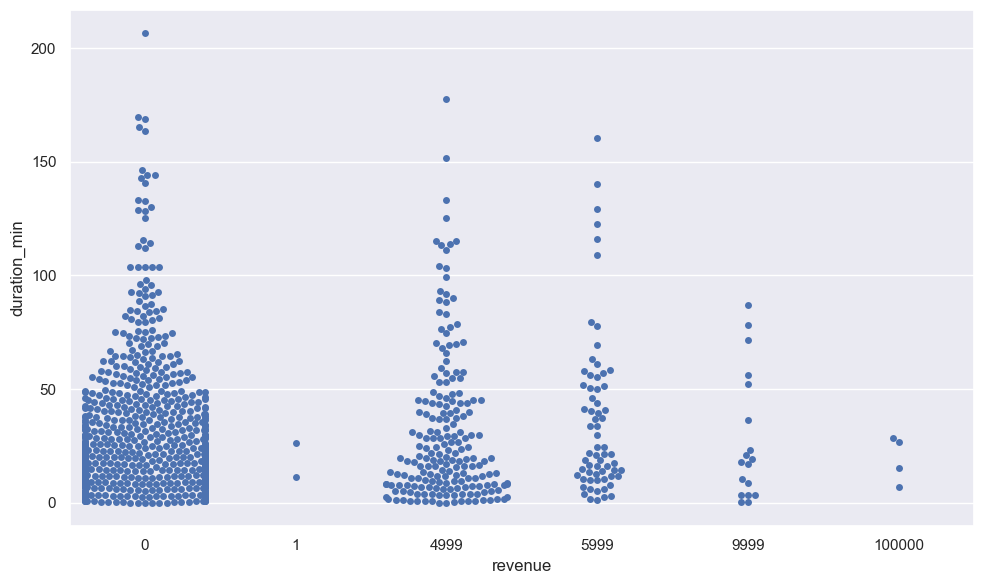

corr = 0.03, p-value = 0.349754


In [12]:
def test_hypothesis_7(data):
    df = data.copy()
    df['duration_min'] = df['sessiondurationsec'] / 60
    plt.figure(figsize=(10, 6))
    sns.swarmplot(x='revenue', y='duration_min', data=df)
    plt.tight_layout()
    plt.show()
    
    corr, p = stats.spearmanr(df['sessiondurationsec'], df['revenue'])
    print(f'corr = {round(float(corr), 2)}, p-value = {round(float(p), 6)}')

test_hypothesis_7(df)
# for df_go, df_name in dfs:
#     print(df_name, test_hypothesis_7(df_go))
#     print()

### `Есть ли взаимосвязь между продолжительностью сессии с рекламным каналом?`

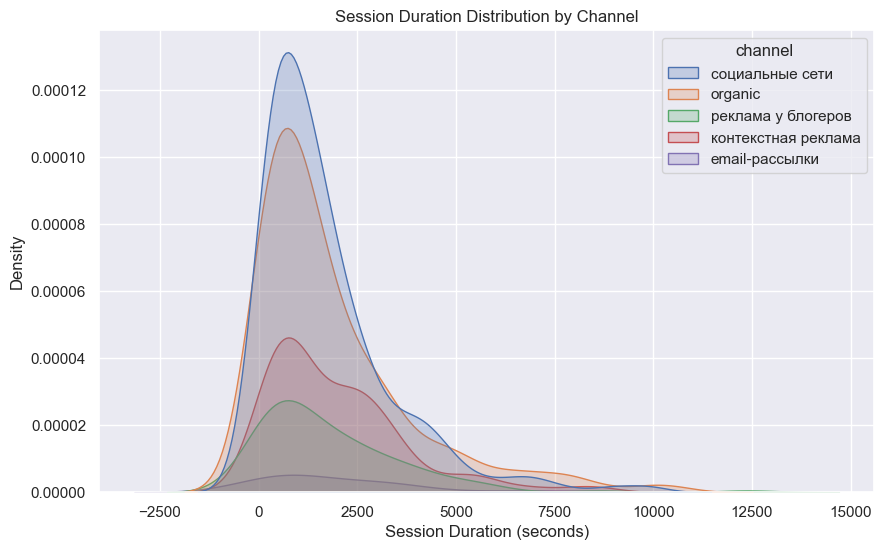

In [13]:
def normality_test(df):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=df, x='sessiondurationsec', hue='channel', fill=True)
    plt.title('Session Duration Distribution by Channel')
    plt.xlabel('Session Duration (seconds)')
    plt.ylabel('Density')
    plt.show()
    
normality_test(df_replaced)

# PROOF THAT IT FOLLOWS GAMMA DISTRIBUTION
# shape, loc, scale = stats.gamma.fit(df['sessiondurationsec'])
# ks_stat, p_value = stats.kstest(df['sessiondurationsec'], "gamma", args=(shape, loc, scale))
# print(f"KS Statistic: {ks_stat}, p-value: {p_value}")

In [14]:
def test_hypothesis_8(df):
    groups = [group.values for channel, group in df.groupby('channel')['sessiondurationsec']]
    stat, p = stats.kruskal(*groups)
    
    return p

for df_go, df_name in dfs:
    print(df_name, test_hypothesis_8(df_go))
    print()

ORIGINAL DATAFRAME: 0.3986706808188171

REPLACED DATAFRAME: 0.3986706808188171

REMOVED DATAFRAME: 0.3995369813670964



<Figure size 1200x600 with 0 Axes>

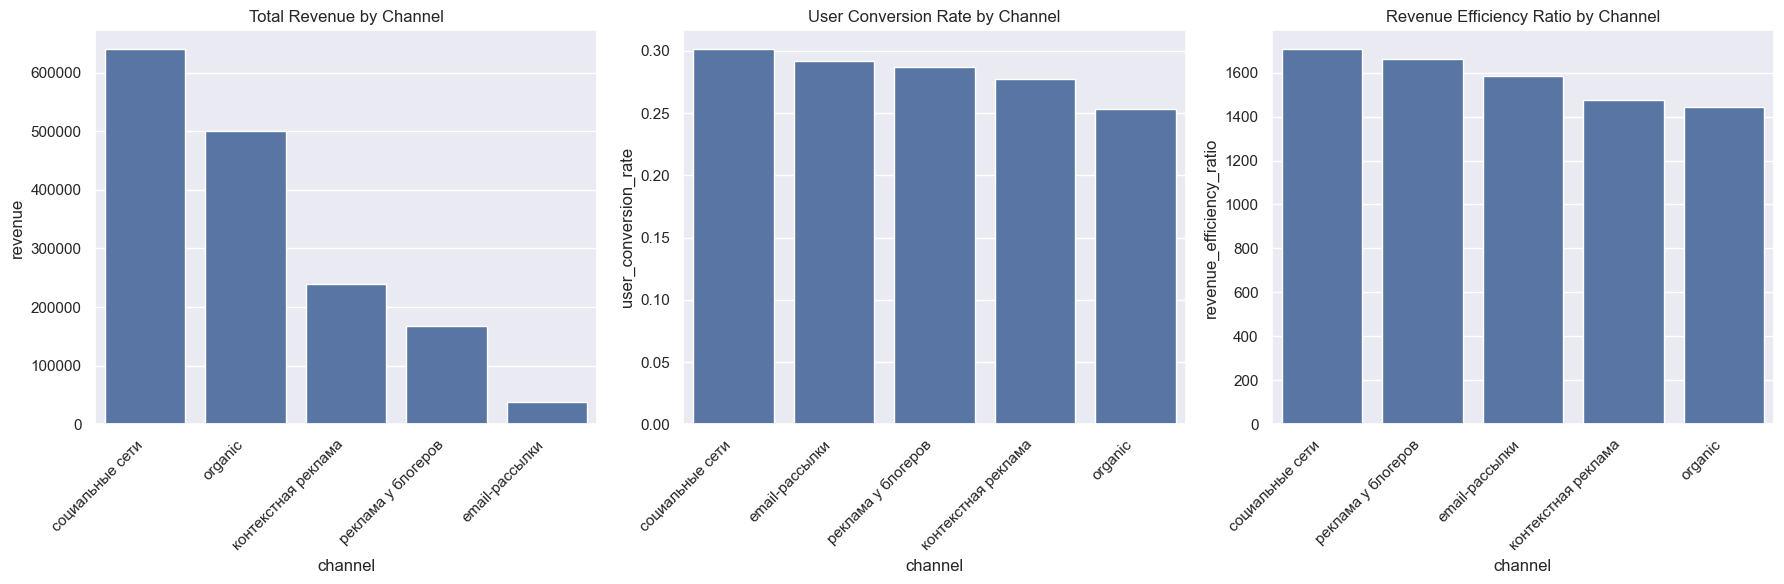

In [33]:
def visualize_channel_performance(channel_metrics):
    plt.figure(figsize=(12, 6))
    
    # Create a subplot grid
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Total Revenue
    sns.barplot(x='channel', y='revenue', data=channel_metrics.sort_values('revenue', ascending=False), ax=axes[0])
    axes[0].set_title('Total Revenue by Channel')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    
    # 2. User Conversion Rate
    sns.barplot(x='channel', y='user_conversion_rate', data=channel_metrics.sort_values('user_conversion_rate', ascending=False), ax=axes[1])
    axes[1].set_title('User Conversion Rate by Channel')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    
    # 3. Revenue Efficiency Ratio
    sns.barplot(x='channel', y='revenue_efficiency_ratio', data=channel_metrics.sort_values('revenue_efficiency_ratio', ascending=False), ax=axes[2])
    axes[2].set_title('Revenue Efficiency Ratio by Channel')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    return plt

# Visualize
plot = visualize_channel_performance(channel_efficiency)
plot.show()